Notes: 
- Ranking the probability of patient's fall (e.g. high risk, etc.) might be enough instead of assigning individual patient's fall/non-fall value.
- Missing nursing data is not MCAR -> dummy variables for unknown values might be a good predictors

In [1]:
# Installations

# %pip install autoviz
# %pip install miceforest
# %pip install prince
# %pip install gower
# %pip install shap

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from autoviz.AutoViz_Class import AutoViz_Class

%matplotlib inline


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# PATIENT FALL RISK ASSESSMENT PROJECT

## Background


The clinic's director seeks to improve patient safety and reduce fall-related incidents. Falls among patients pose a significant risk, leading to severe health complications and increased healthcare costs. To address this issue, a data-driven assessment is required to better understand the factors contributing to falls and to develop predictive measures for mitigating them effectively.

The dataset used for this analysis consists of patient-related information, categorized into two types:

 - Medical Data: Collected upon patient admission and during patient stay, this dataset includes age, gender, diagnosis, and procedure. This data is always available for every patient.

 - Nursing Data: The remaining variables in this dataset come from the so-called fall risk assessment. This assessment is conducted by nurses and contains various risk factors that are assumed to contribute to patient falls. Unlike medical data, nursing data is manually recorded and is only collected for specific patients—namely, those deemed at an increased risk of falling or those who exceed a certain age threshold. From these variables also the variable fall risk is derived, that is the traditional nursing assessment of a patient’s fall risk.

Our task is to conduct a predictive analytics project with two main objectives:

1) Develop a reliable assessment of the risk of patient falls based on historical data.

2) Identify key factors that contribute to fall incidents.

## Section 1: Data Overview and Preparation

In this section, we:
 - Provide a clear and intuitive summary of the dataset.

 - Define an approach to identify outliers and implement an appropriate method to handle them.

 - Identify and assess missing data. Define an approach to handle the missing data.

 - Establish an appropriate strategy for partitioning training and testing datasets


### 1. SUMMARY OF THE DATASET

In [3]:
# Load the dataset
path = "../data/kip_sdm_syn.csv"
df = pd.read_csv(path)

# Display the first few rows to understand the structure
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-impairment,bed_mobility-jones,bed_mobility-skin_condition,transfer-impairment,transfer,medical_items,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,medical_items-ventilation_mask,medical_items-O2_glasses,medical_items-orthesis,medical_items-prosthesis,medical_items-skin_condition_at_item_application,fall-last_12_month,fall-how_many_last_12_month,fall-while_stay,fall-while_transfer,walk-impairment,walk-jones,walk-balance_and_gait_impaired,walking_aid,excretions-impairment,excretions-incontinence,excretions-nykturie,cognition-impairment,cognition-disoriented_time,cognition-disoriented_location,cognition-disoriented_own_person,cognition-agitated,cognition-confused,psychotropic_or_sedatives_drugs,decubitus-risk,fall-risk,diseases,sex
0,False,179020,39,0,S250,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2,False,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,False,female
1,False,112009,29,0,M418,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,male
2,False,54403,29,9-26,S910,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,NaN,NaN,0,NaN,female
3,False,13054,64,8-77,M400,True,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False,False,NaN,False,False,True,True,False,NaN,False,False,False,False,False,False,0,0,False,male
4,False,45770,89,8-93,K630,False,NaN,False,NaN,NaN,NaN,NaN,2,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,male


#### Identify Target and 'id'

In [4]:
# 'fallen' is the target: "Ist der Patient gestürzt?" (logical => True/False).
# 'id' is just an identifier, so typically we don't use it for modeling.

if "id" in df.columns:
    # Keep 'id' in the dataframe for reference if needed, but do not model with it
    pass
	# df.drop(columns=["id"], inplace=True)

if "fallen" not in df.columns:
    raise ValueError("Target column 'fallen' not found in dataset. Please verify.")

#### Shape and Data Types

In [5]:
print("Number of rows and columns:", df.shape)
print("\nData Types:\n", df.dtypes.value_counts())
print("\nColumn Names:\n", df.columns.tolist())

Number of rows and columns: (40000, 45)

Data Types:
 object     23
bool       19
int64       2
float64     1
Name: count, dtype: int64

Column Names:
 ['fallen', 'id', 'age', 'procedure', 'diagnosis', 'c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-jones', 'bed_mobility-skin_condition', 'transfer-impairment', 'transfer', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-how_many_last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-jones', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disorie

In [5]:
# List all variable names and their data types
print("\nVariable names and their data types:")
print(df.dtypes)  # Displays column names with their data types


Variable names and their data types:
fallen                                                 bool
id                                                    int64
age                                                   int64
procedure                                            object
diagnosis                                            object
c_zriserh1                                             bool
decubitus-admission                                  object
decubitus-at_the_moment                              object
bed_mobility-impairment                              object
bed_mobility-jones                                   object
bed_mobility-skin_condition                          object
transfer-impairment                                  object
transfer                                             object
medical_items                                        object
medical_items-arm_or_leg_splint                        bool
medical_items-A_V_system                               bool
me

#### Distribution of the Target Variable `fallen`

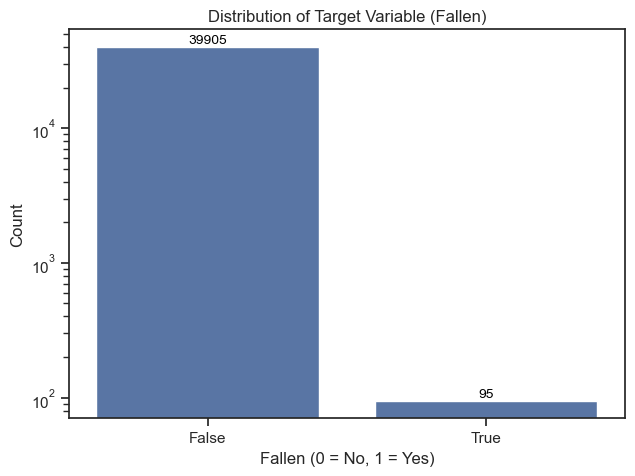

In [7]:
sns.countplot(data=df, x='fallen')
plt.title('Distribution of Target Variable (Fallen)')
plt.xlabel('Fallen (0 = No, 1 = Yes)')
plt.ylabel('Count')

# Annotate the bars with their respective counts
for p in plt.gca().patches:
	count = int(p.get_height())
	plt.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
				 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
				 textcoords='offset points')

plt.yscale('log')  # Use logarithmic scale for better visualization
plt.show()

In [8]:
print("Value distribution for 'fallen':")
print(df['fallen'].value_counts())
fall_counts = df['fallen'].value_counts(normalize=True) * 100
print("\nPercentage of Fall Incidents:\n", fall_counts.round(2))

Value distribution for 'fallen':
fallen
False    39905
True        95
Name: count, dtype: int64

Percentage of Fall Incidents:
 fallen
False    99.76
True      0.24
Name: proportion, dtype: float64


#### CHECK MISSING VALUES

In [23]:
# Calculate missing values and percentages for all columns
missing = df.isnull().sum()
missing_percentage = (missing / len(df)) * 100

# Create a DataFrame for the summary
missing_summary = pd.DataFrame({
	'Missing Values': missing,
	'Percentage': missing_percentage.round(2)
}).sort_values(by='Percentage', ascending=False)

# Display the summary
print("\nMissing Values per Column:\n", missing_summary)


Missing Values per Column:
                                                   Missing Values  Percentage
medical_items-skin_condition_at_item_application       38637         96.59  
fall-how_many_last_12_month                            38600         96.50  
bed_mobility-skin_condition                            38447         96.12  
bed_mobility-jones                                     37593         93.98  
fall-while_stay                                        37212         93.03  
transfer                                               36994         92.48  
walk-jones                                             35627         89.07  
decubitus-admission                                    30601         76.50  
decubitus-at_the_moment                                30401         76.00  
psychotropic_or_sedatives_drugs                        30203         75.51  
diseases                                               29956         74.89  
cognition-impairment                           

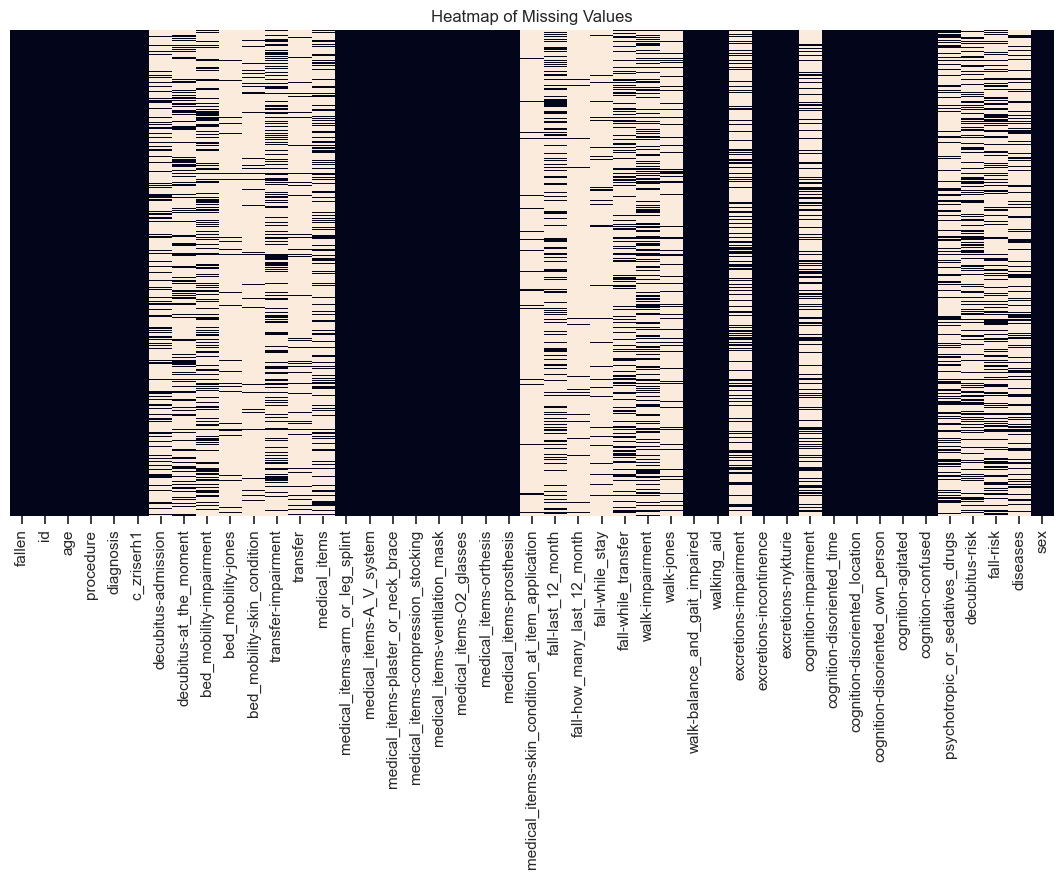

In [10]:
# Visualizing missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

#### Transform and Categorize Variables

From the provided explanations, we have the following columns to consider:
  - Columns with 0 missing values (fully recorded).
  - Logical columns with high missingness => means "not assessed" or "unknown".
  - Jones score columns (character) that might hold numeric or ordinal values.
  - 'decubitus-risk' and 'fall-risk' (character) with values {0, +, ++}
  - `sex` with values {male, female}
  - 'c_zriserh1' is undocumented => decide whether to keep or drop.

##### Mapping `decubitus-risk` and `fall-risk`

In [6]:
# Convert 'decubitus-risk' and 'fall-risk' from {0, +, ++} to ordinal numeric
#     For example: 0 -> 0, + -> 1, ++ -> 2. If these are truly ordinal risk levels,
#     it helps to store them numerically.
risk_mapping = {"0": 0, "+": 1, "++": 2}

if "decubitus-risk" in df.columns:
    df["decubitus-risk"] = df["decubitus-risk"].map(risk_mapping).astype("Int64")

if "fall-risk" in df.columns:
    df["fall-risk"] = df["fall-risk"].map(risk_mapping).astype("Int64")

In [7]:
print("Unique values and their counts for 'decubitus-risk':")
print(df['decubitus-risk'].value_counts(dropna=False))

Unique values and their counts for 'decubitus-risk':
decubitus-risk
<NA>    28511
0        8686
1        2193
2         610
Name: count, dtype: Int64


In [8]:
print("Unique values and their counts for 'fall-risk':")
print(df['fall-risk'].value_counts(dropna=False))

Unique values and their counts for 'fall-risk':
fall-risk
<NA>    27672
0        8446
1        3685
2         197
Name: count, dtype: Int64


##### Mapping `sex`

In [9]:
# Convert 'sex' to binary values and handle missing values
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

In [28]:
print("Unique values and their counts for 'sex':")
print(df['sex'].value_counts(dropna=False))

Unique values and their counts for 'sex':
sex
1    21371
0    18629
Name: count, dtype: int64


##### Categorize Numerical Variables

In [10]:
# # Automatically select numerical variables
# Exclude 'id' from numerical_vars

numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns.difference(['id', 'sex'])
print("Numerical variables (excluding 'id'):", numerical_vars.tolist())

Numerical variables (excluding 'id'): ['age', 'decubitus-risk', 'fall-how_many_last_12_month', 'fall-risk']


##### Inspect statistics for numerical variables

In [11]:
print("Statistics for numerical variables:")
numerical_stats = df[numerical_vars].describe().T  # Transpose for better readability
numerical_stats["variance"] = df[numerical_vars].var()  # Add variance column
print(numerical_stats)

Statistics for numerical variables:
                             count      mean      std      min   25%   50%   \
age                          40000.0     57.66  19.124127  19.0  39.0  59.0   
decubitus-risk               11489.0  0.297067   0.561279   0.0   0.0   0.0   
fall-how_many_last_12_month   1400.0  1.754659    1.54334   1.0   1.0   1.0   
fall-risk                    12328.0  0.330873   0.503365   0.0   0.0   0.0   

                             75%   max     variance   
age                          74.0  104.0  365.732243  
decubitus-risk                0.0    2.0    0.315034  
fall-how_many_last_12_month   1.0    5.0    2.381899  
fall-risk                     1.0    2.0    0.253376  


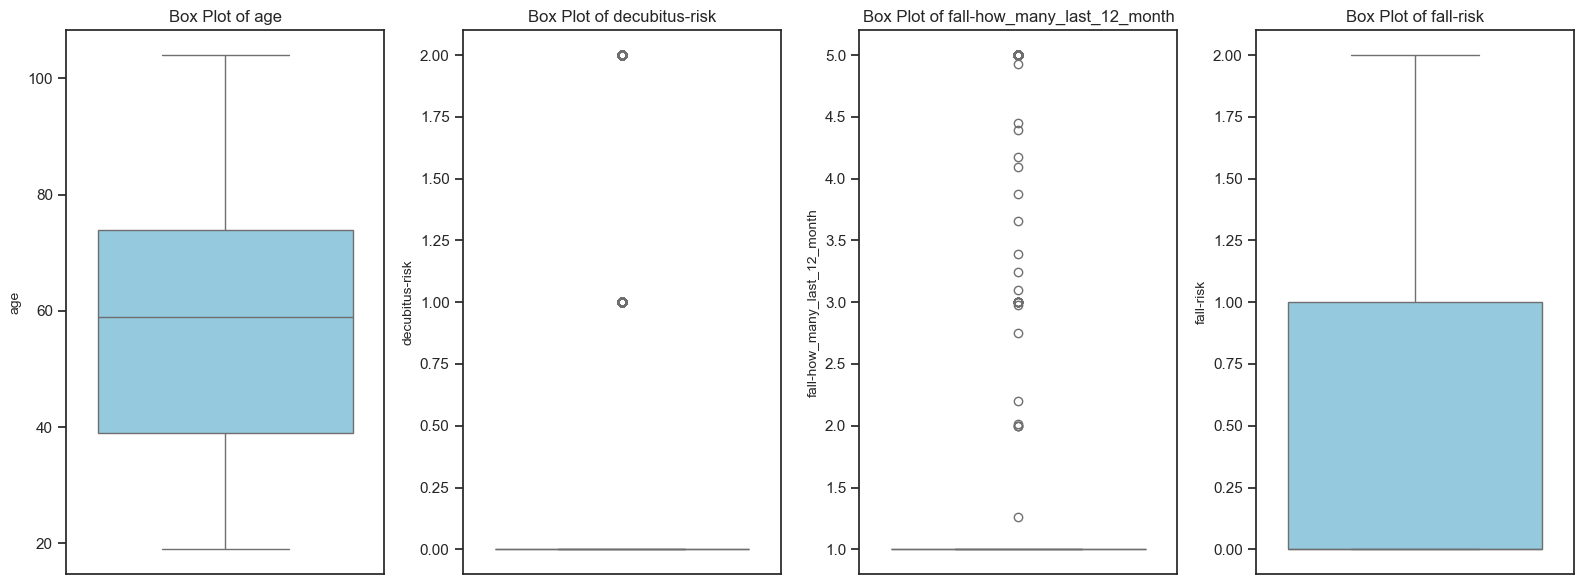

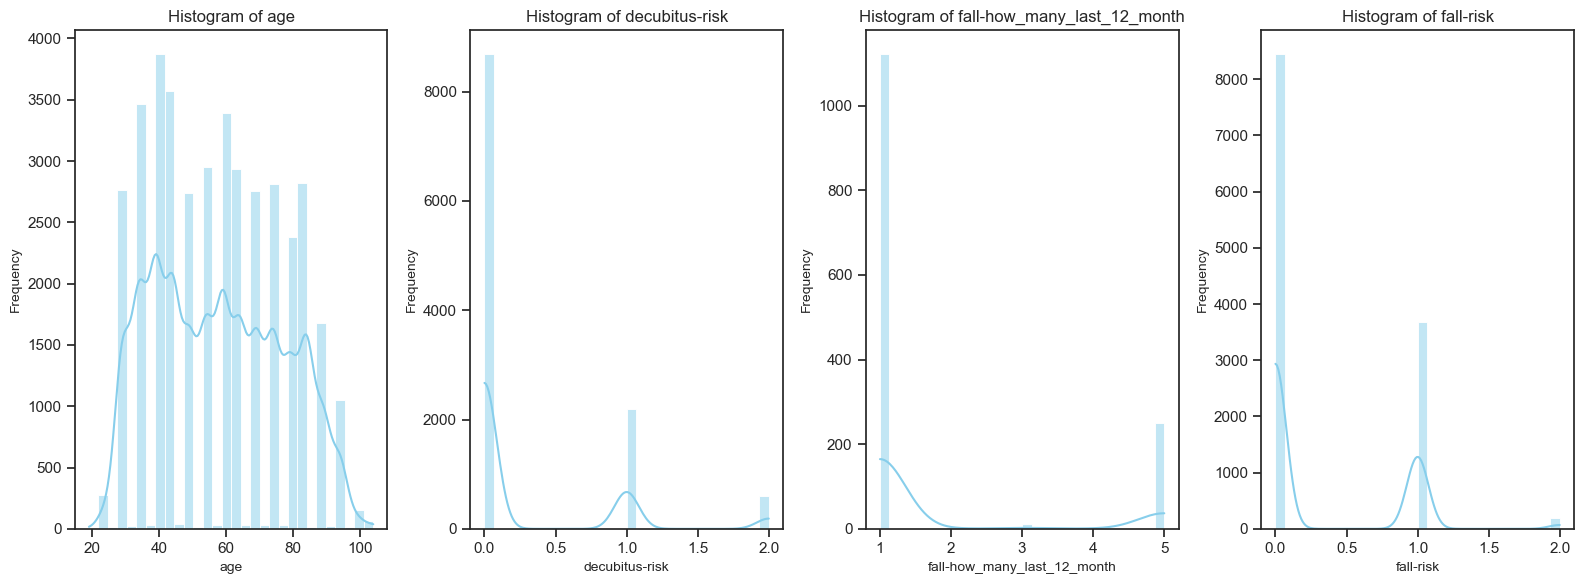

In [12]:
# Create side-by-side box plots for numerical variables
plt.figure(figsize=(16, 6))  # Adjust the figure size for better visualization

# Loop through numerical variables and create subplots
for i, col in enumerate(numerical_vars):
	plt.subplot(1, len(numerical_vars), i + 1)  # Create subplots in a single row
	sns.boxplot(y=df[col], color='skyblue')  # Use a consistent color for all plots
	plt.title(f'Box Plot of {col}', fontsize=12)  # Add title
	plt.ylabel(col, fontsize=10)  # Add y-axis label
	plt.xlabel('')  # Remove x-axis label for cleaner look
	plt.xticks([])  # Remove x-axis ticks for cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Create histograms for numerical variables
plt.figure(figsize=(16, 6))  # Adjust the figure size for better visualization

# Loop through numerical variables and create subplots
for i, col in enumerate(numerical_vars):
	plt.subplot(1, len(numerical_vars), i + 1)  # Create subplots in a single row
	sns.histplot(df[col], kde=True, color='skyblue', bins=30)  # Histogram with KDE overlay
	plt.title(f'Histogram of {col}', fontsize=12)  # Add title
	plt.xlabel(col, fontsize=10)  # Add x-axis label
	plt.ylabel('Frequency', fontsize=10)  # Add y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##### Categorize Categorical/Bool Variables

Upon examination, some features are recognized automatically as `object`.
We did further inspection to determine if the data types are properly assigned.
We determined the features that should be encoded as `bool` and convert them accoringly.

In [17]:
bool_vars = [
    "c_zriserh1",
    "decubitus-admission",
    "decubitus-at_the_moment",
    "bed_mobility-impairment",
    "bed_mobility-skin_condition",
    "transfer-impairment",
    "medical_items",
    "medical_items-skin_condition_at_item_application",
    "fall-last_12_month",
    "fall-while_stay",
    "fall-while_transfer",
    "walk-impairment",
    "excretions-impairment",
    "cognition-impairment",
    "psychotropic_or_sedatives_drugs",
    "diseases",
]

df[bool_vars] = df[bool_vars].astype("boolean")
# df.dtypes

In [34]:
categorical_vars = ['procedure', 'diagnosis', 'bed_mobility-jones', 'transfer', 'walk-jones', 'sex']
ordinal_vars = []
bool_vars = ['c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition-confused', 'psychotropic_or_sedatives_drugs', 'diseases']
id_vars = ['id']

##### Check for Correct Categorization

In [40]:
# Print categorized variables
print("Numerical variables:", numerical_vars)
print("Categorical variables:", categorical_vars)
print("Ordinal variables:", ordinal_vars)
print("Boolean variables:", bool_vars)
print("ID variables:", id_vars)

# Check if all columns are categorized and there are no duplicates
all_categorized_columns = set(numerical_vars + categorical_vars + ordinal_vars + bool_vars + id_vars)
all_columns = set(df.columns)

# Find missing columns
missing_columns = all_columns - all_categorized_columns
if missing_columns:
	print("\nMissing columns that are not categorized:", missing_columns)
else:
	print("\nAll columns are categorized.")

# Find duplicate columns
duplicate_columns = [col for col in all_categorized_columns if list(all_categorized_columns).count(col) > 1]
if duplicate_columns:
	print("\nDuplicate columns found in categories:", duplicate_columns)
else:
	print("\nNo duplicate columns in categories.")

print(f'\n\nNumber of columns including `fallen`: {len(numerical_vars) + len(categorical_vars) + len(ordinal_vars) + len(bool_vars) + len(id_vars) + 1}')

Numerical variables: ['age', 'fall-how_many_last_12_month', 'decubitus-risk', 'fall-risk']
Categorical variables: ['procedure', 'diagnosis', 'bed_mobility-jones', 'transfer', 'walk-jones', 'sex']
Ordinal variables: []
Boolean variables: ['c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location

### 2. HANDLING MISSING VALUES

#### HANDLING MISSING NUMERICAL VARIABLES THROUGH SINGLE IMPUTATION


##### 🧾 Imputation Strategy Summary

| Variable                        | Data Type              | Chosen Method | Reason                                                                 |
|---------------------------------|------------------------|----------------|------------------------------------------------------------------------|
| `age`                           | Numerical              | —              | No missing values — imputation not needed.                            |
| `fall-how_many_last_12_month`   | Discrete count         | **Median (1)** | Skewed distribution; median avoids fractional imputation (mean = 1.75). |
| `decubitus-risk`               | Categorical (ordinal)  | **Mode (0)**   | Most values are 0; small integer range (0–2); avoid mean (0.297).     |
| `fall-risk`                    | Categorical (ordinal)  | **Mode (0)**   | Strongly skewed to 0; mean (0.33) not compatible with integer dtype.  |


In [42]:
df_before = df.copy()

# Fix by rounding and converting to integer
df['fall-how_many_last_12_month'] = df['fall-how_many_last_12_month'].round().astype('Int64')
df['fall-how_many_last_12_month'] = df['fall-how_many_last_12_month'].fillna(
    df['fall-how_many_last_12_month'].median()
)

df['decubitus-risk'] = df['decubitus-risk'].fillna(df['decubitus-risk'].mode()[0])

df['fall-risk'] = df['fall-risk'].fillna(df['fall-risk'].mode()[0])

print("Number of missing values after single imputation: ")
print(df[numerical_vars].isnull().sum())
print("\nFall-risk mode:", df['fall-risk'].mode()[0])
print("Fall-how-many-last-12-month median:", df['fall-how_many_last_12_month'].median())
print("Decubitus-risk mode:", df['decubitus-risk'].mode()[0])


Number of missing values after single imputation: 
age                            0
fall-how_many_last_12_month    0
decubitus-risk                 0
fall-risk                      0
dtype: int64

Fall-risk mode: 0
Fall-how-many-last-12-month median: 1.0
Decubitus-risk mode: 0


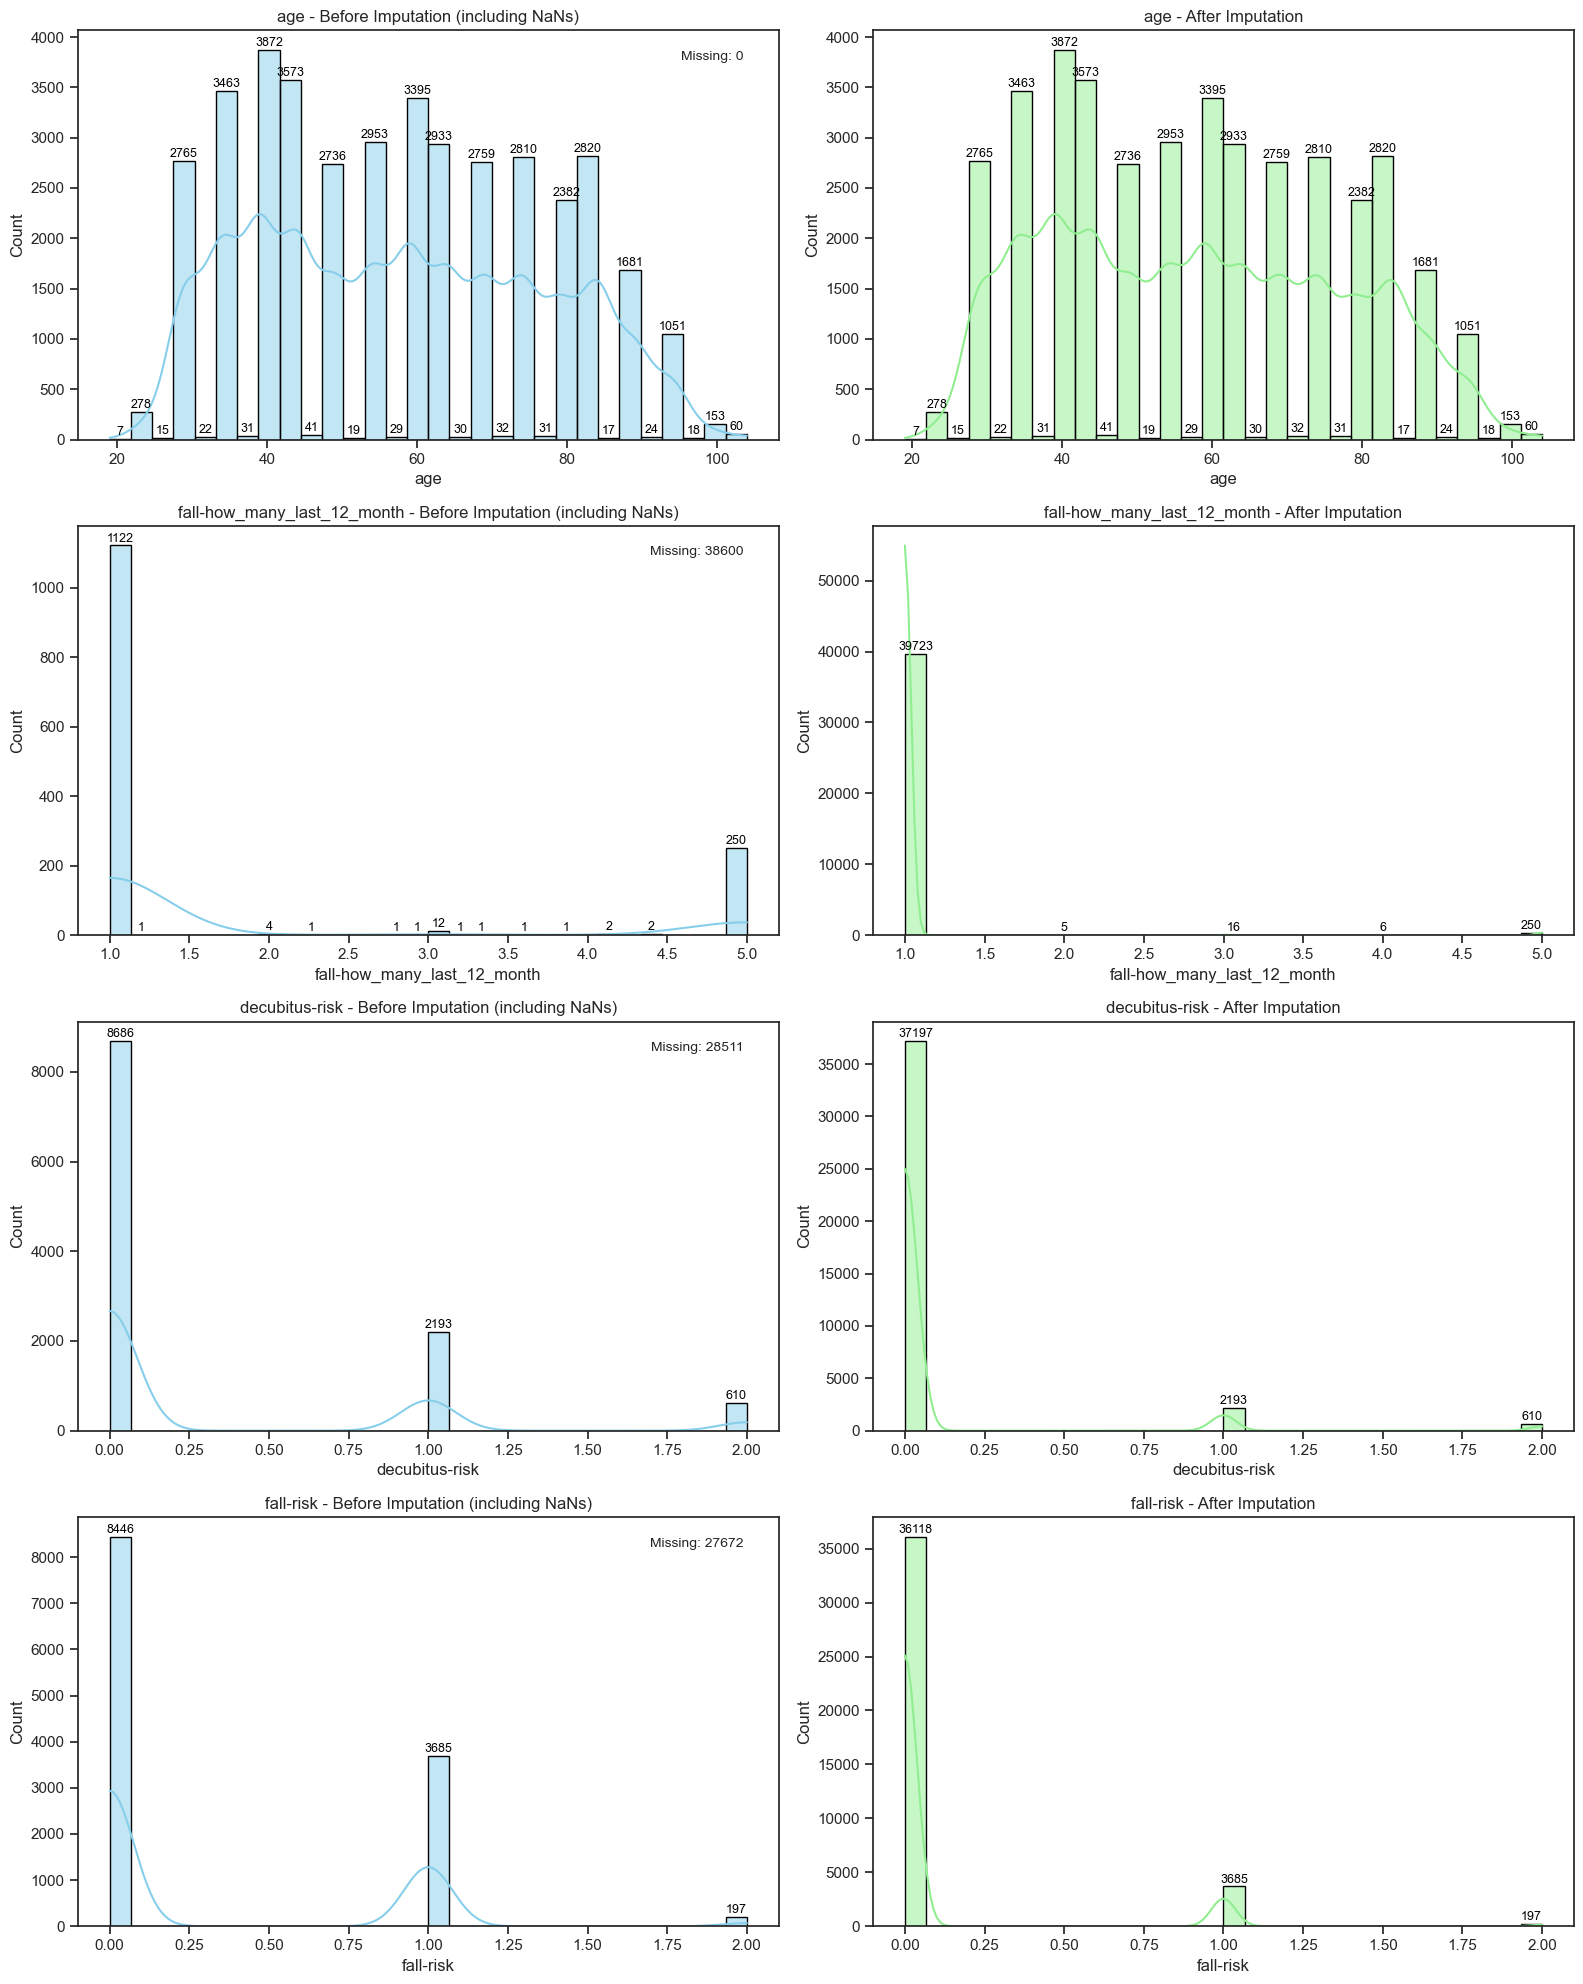

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set up the plot
plt.figure(figsize=(16, 5 * len(numerical_vars)))

for i, col in enumerate(numerical_vars):
	plt.subplot(len(numerical_vars), 2, 2 * i + 1)
	hist_before = sns.histplot(df_before[col], bins=30, kde=True, color="skyblue", edgecolor="black")
	plt.title(f'{col} - Before Imputation (including NaNs)')
	plt.xlabel(col)
	plt.ylabel('Count')

	# Annotate the bars with their respective counts
	for p in hist_before.patches:
		if p.get_height() > 0:  # Avoid annotating bars with zero height
			plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
						 ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
						 textcoords='offset points')

	# Show number of missing values
	na_count = df_before[col].isna().sum()
	plt.annotate(f'Missing: {na_count}', xy=(0.95, 0.95), xycoords='axes fraction',
				 ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', fc='white'))

	plt.subplot(len(numerical_vars), 2, 2 * i + 2)
	hist_after = sns.histplot(df[col], bins=30, kde=True, color="lightgreen", edgecolor="black")
	plt.title(f'{col} - After Imputation')
	plt.xlabel(col)
	plt.ylabel('Count')

	# Annotate the bars with their respective counts
	for p in hist_after.patches:
		if p.get_height() > 0:  # Avoid annotating bars with zero height
			plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
						 ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
						 textcoords='offset points')

plt.tight_layout()
plt.show()


### CATEGORICAL VARIABLES

In [48]:
# Calculate the percentage of missing values for categorical variables
categorical_na_percentage = df[categorical_vars].isna().mean() * 100

# Print the result
print("Percentage of missing values for categorical variables:")
print(categorical_na_percentage)


Percentage of missing values for categorical variables:
procedure              0.0000
diagnosis              0.0000
bed_mobility-jones    93.9825
transfer              92.4850
walk-jones            89.0675
sex                    0.0000
dtype: float64


### 🧾 Handling Missing Values and Encoding for Categorical Variables

| Column               | # Unique Values | Missing % | Imputation Strategy         | Encoding Strategy             | Notes                                                                 |
|----------------------|------------------|------------|-----------------------------|-------------------------------|-----------------------------------------------------------------------|
| `procedure`          | ~250+            | Low        | Fill with `'Unknown'`       | Frequency or Target Encoding  | Too many categories for one-hot; consider grouping rare ones.        |
| `diagnosis`          | 3,345            | Low        | Fill with `'Unknown'`       | Target Encoding or Embedding  | Very high cardinality — one-hot not practical.                       |
| `bed_mobility-jones` | 6                | ~93%       | Fill with `'Missing'`       | One-hot or Ordinal Encoding   | Small number of categories — treat missing as valid category.        |
| `transfer`           | 6                | ~92%       | Fill with `'Missing'`       | One-hot or Ordinal Encoding   | Same as above.                                                        |
| `walk-jones`         | 6                | ~89%       | Fill with `'Missing'`       | One-hot or Ordinal Encoding   | Same as above.                                                        |
| `sex`                | 2 (0, 1)         | None       | —                           | Use as-is                     | Already binary — no transformation needed.                           |


In [21]:
# df['procedure'] = df['procedure'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['procedure'])


# df['diagnosis'] = df['diagnosis'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['diagnosis'])


# df['transfer'] = df['transfer'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['transfer'])

# df['bed_mobility-jones'] = df['bed_mobility-jones'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['bed_mobility-jones'])

# # df['decubitus-risk'] = df['decubitus-risk'].fillna('Unknown')
# # df = pd.get_dummies(df, columns=['decubitus-risk'])

# df['fall-risk'] = df['fall-risk'].fillna('Unknown')
# df = pd.get_dummies(df, columns=['fall-risk'])


## BAD IDEA? Create length=3609 columns

In [22]:
# import prince

# df_backup = df.copy

# target = 'fallen'
# id_var = 'id'

# # Create feature matrix X (drop target + ID)
# X = df.drop(columns=[target, id_var])


# # Force numerical columns to float64 (not nullable Int64)
# for col in numerical_vars:
#     X[col] = pd.to_numeric(X[col], errors='coerce').astype(float)  # 💥 this line is key
#     print(f"{col}: {X[col].dtype}")



# for col in categorical_vars + bool_vars:
#     X[col] = X[col].astype(str).fillna('missing')

# # ✅ Step 3: Run FAMD
# famd = prince.FAMD(n_components=5, random_state=42)
# X_famd = famd.fit_transform(X)



In [23]:
# print(X_famd.head())
# print(X_famd.shape)


In [24]:
# famd.column_correlations(X)


In [25]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Add the target back for coloring
# X_famd['fallen'] = df['fallen'].values

# # Plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=X_famd,
#     x=0, y=1,
#     hue='fallen',
#     palette='Set1',
#     alpha=0.7
# )
# plt.title('FAMD Projection: First 2 Components')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.legend(title='Fallen')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### BOOLEAN VARIABLE

In [26]:
# Calculate the percentage of missing values for boolean variables
bool_na_percentage = df[bool_vars].isna().mean() * 100

# Print the result
print("Percentage of missing values for boolean variables:")
print(bool_na_percentage)

Percentage of missing values for boolean variables:
c_zriserh1                                           0.0000
decubitus-admission                                 76.5025
decubitus-at_the_moment                             76.0025
bed_mobility-impairment                             72.1800
bed_mobility-skin_condition                         96.1175
transfer-impairment                                 71.4700
medical_items                                       73.0075
medical_items-arm_or_leg_splint                      0.0000
medical_items-A_V_system                             0.0000
medical_items-plaster_or_neck_brace                  0.0000
medical_items-compression_stocking                   0.0000
medical_items-ventilation_mask                       0.0000
medical_items-O2_glasses                             0.0000
medical_items-orthesis                               0.0000
medical_items-prosthesis                             0.0000
medical_items-skin_condition_at_item_application

### 🧾 Strategy for Handling Boolean Variables with Missing Values

In [27]:
# TODO: Add _missing column for important vars?

## DIMENSIONALITY REDUCTION

### PCA FOR NUMERICAL VARIABLES

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_num = df[numerical_vars].copy()
X_num = StandardScaler().fit_transform(X_num)

pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X_num), columns=['pca1', 'pca2', 'pca3'])


### MCA FOR CATEGORICAL AND BOOL VARIABLES

In [29]:
X_cat = df[categorical_vars + bool_vars].copy()
for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype(str).fillna('missing')

import prince
mca = prince.MCA(n_components=3, random_state=42)
X_mca = mca.fit_transform(X_cat)
X_mca.columns = ['mca1', 'mca2', 'mca3']


### COMBINING PCA AND MCA RESULT

In [30]:
X_combined = pd.concat([X_pca, X_mca], axis=1)
X_combined['fallen'] = df['fallen'].values


### GET IMPORTANCE

In [31]:
# Absolute values of PCA component loadings (columns = components, rows = variables)
loadings = pd.DataFrame(
    abs(pca.components_.T),
    index=numerical_vars,
    columns=['pca1', 'pca2', 'pca3']
)

# Overall contribution per variable (sum across components)
pca_importance = loadings.sum(axis=1).sort_values(ascending=False)

print("🔵 Top contributing numerical variables to PCA:")
print(pca_importance)

print(loadings)

🔵 Top contributing numerical variables to PCA:
age                            1.397683
fall-how_many_last_12_month    1.257309
decubitus-risk                 1.228470
fall-risk                      0.949990
dtype: float64
                               pca1      pca2      pca3  
age                          0.363628  0.110861  0.923194
fall-how_many_last_12_month  0.301771  0.939719  0.015819
decubitus-risk               0.601670  0.311684  0.315116
fall-risk                    0.643973  0.086552  0.219465


In [32]:
def auto_label_pca_components(loadings, top_n=2):
    """
    Creates human-readable labels for each PCA component
    based on top contributing features.

    Parameters:
        loadings (pd.DataFrame): Output from plot_pca_loadings (or equivalent)
        top_n (int): Number of top features to include in label

    Returns:
        pd.Series: Mapping of PCA component to its label
    """
    labels = {}
    for comp in loadings.columns:
        top_features = loadings[comp].abs().sort_values(ascending=False).head(top_n).index
        label = " + ".join(top_features)
        labels[comp] = f"{comp} ({label})"
    return pd.Series(labels)
pca_labels = auto_label_pca_components(loadings)
print(pca_labels)


pca1                      pca1 (fall-risk + decubitus-risk)
pca2    pca2 (fall-how_many_last_12_month + decubitus-risk)
pca3                            pca3 (age + decubitus-risk)
dtype: object


### 🔍 PCA Component Interpretation

#### 🔹 PCA1
- **Top contributing variables:**
  - `fall-risk` (0.64)
  - `decubitus-risk` (0.60)
  - `age` (0.36)
- **Interpretation:**  
  PCA1 likely represents **overall clinical risk**, combining multiple risk-related scores.
  pca1 = 0.64 * fall-risk + 0.60 * decubitus-risk + 0.36 * age
  It’s not saying any single variable dominates, but that together they define a new direction of variation.

#### 🔹 PCA2
- **Top contributing variable:**
  - `fall-how_many_last_12_month` (0.94)
- **Interpretation:**  
  PCA2 captures **fall frequency** — it acts almost as a proxy for that column.
  fall-how_many_last_12_month has high variance but low correlation with the others.
  So PCA2 mostly points in its direction alone.

#### 🔹 PCA3
- **Top contributing variable:**
  - `age` (0.92)
- **Interpretation:**  
  PCA3 primarily reflects **age-related variation** in the dataset.
  age dominates PCA3, meaning it contributes unique variance not captured by PCA1 or PCA2.


In [33]:
# Absolute values of each category's coordinate (like PCA loadings)
mca_contrib = mca.column_coordinates(X_cat).abs().sum(axis=1)

# Group by original variable name
mca_importance = mca_contrib.groupby(lambda x: x.split('_')[0]).sum().sort_values(ascending=False)

print("🟣 Top contributing categorical/boolean variables to MCA:")
print(mca_importance)


🟣 Top contributing categorical/boolean variables to MCA:
diagnosis                  3080.814043
procedure                   188.077129
bed                         127.580835
transfer                     85.445353
medical                      63.903992
walk-jones                   50.550923
cognition-disoriented        46.425536
decubitus-at                 19.899307
cognition-agitated           13.639007
cognition-confused           13.365609
cognition-impairment         12.040278
fall-while                   11.166418
excretions-incontinence       6.717294
excretions-impairment         6.357711
transfer-impairment           5.654541
walking                       5.471498
walk-impairment               5.027196
excretions-nykturie           4.844442
walk-balance                  4.625897
fall-last                     3.661415
psychotropic                  3.470140
diseases                      2.812665
c                             1.625201
sex                           0.099730
decubit

ISSUE:
- In MCA, `diagnosis` has over 3000 unique values, so it's contributing 3000 rows to the MCA column coordinate matrix.
- Even if each category contributes a small value (e.g., ~1), the total for diagnosis ends up large.
- MCA works on dummy-encoded variables (categories), not columns

> MCA contribution scores are biased by the number of levels in a variable.

HOW TO FIX: Normalize by number of categories

In [45]:
# Step 1: Get original feature names mapped to dummy-encoded columns
def extract_variable_name(colname):
    for original_col in X_cat.columns:
        if colname.startswith(original_col + '_') or colname == original_col:
            return original_col
    return colname  # fallback just in case

# Step 2: Apply the mapping to group contributions
mca_contrib = mca.column_coordinates(X_cat).abs().sum(axis=1)

# Map each dummy column back to its source feature
grouped_names = mca_contrib.index.to_series().apply(extract_variable_name)

# Group and normalize
mca_importance = mca_contrib.groupby(grouped_names).sum()
category_counts = grouped_names.value_counts()
mca_importance_normalized = (mca_importance / category_counts).sort_values(ascending=False)

# Show result
print("🟣 MCA Variable Importance (Normalized):")
print(mca_importance_normalized.head(10))
print("This tells you:Which variables are most influential across all components combined?")


🟣 MCA Variable Importance (Normalized):
bed_mobility-jones                  17.272144
transfer                            14.240892
walk-jones                           8.425154
cognition-disoriented_own_person     8.369899
cognition-disoriented_location       7.645881
cognition-disoriented_time           7.196988
cognition-agitated                   6.819503
cognition-confused                   6.682805
decubitus-at_the_moment              6.633102
bed_mobility-skin_condition          6.078763
dtype: float64
This tells you:Which variables are most influential across all components combined?


In [40]:
# 1. Get column coordinates (aka loadings)
col_coords = mca.column_coordinates(X_cat)  # shape: (dummy_vars x components)

# 2. Optional: absolute value of each dummy variable's contribution
abs_coords = col_coords.abs()

# 3. Map each dummy column back to original variable name
def extract_variable_name(colname):
    for original_col in X_cat.columns:
        if colname.startswith(original_col + '_') or colname == original_col:
            return original_col
    return colname

# 4. Create variable mapping
grouped_names = abs_coords.index.to_series().apply(extract_variable_name)

# 5. Group by original variable and sum contributions per component
variable_component_contrib = abs_coords.groupby(grouped_names).sum()

# 6. Normalize by number of dummy columns to avoid bias
category_counts = grouped_names.value_counts()
variable_component_contrib_normalized = variable_component_contrib.div(category_counts, axis=0)

# 7. Show top contributing variables per component
for i in range(3):
    print(f"\n🔎 Top variables contributing to MCA Component {i+1}:")
    print(variable_component_contrib_normalized[i].sort_values(ascending=False).head(10))



🔎 Top variables contributing to MCA Component 1:
bed_mobility-jones                  4.321610
cognition-disoriented_own_person    4.078847
transfer                            3.967904
cognition-agitated                  3.736619
cognition-disoriented_location      3.717450
cognition-disoriented_time          3.537051
walk-jones                          3.404284
cognition-confused                  3.110781
excretions-incontinence             2.403422
decubitus-at_the_moment             2.328450
Name: 0, dtype: float64

🔎 Top variables contributing to MCA Component 2:
bed_mobility-jones                  4.836336
transfer                            3.701740
cognition-disoriented_own_person    3.241795
cognition-agitated                  2.846187
cognition-disoriented_location      2.671013
walk-jones                          2.544971
medical_items-orthesis              2.397982
cognition-disoriented_time          2.391179
cognition-confused                  1.957387
medical_items-arm_or_

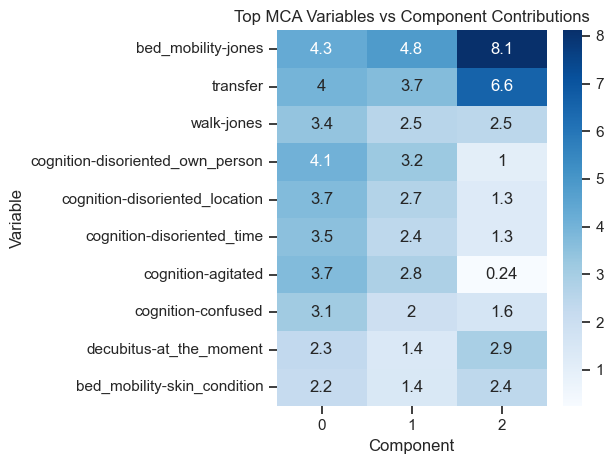

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the per-component normalized contribution matrix
heatmap_data = variable_component_contrib_normalized.loc[
    mca_importance_normalized.head(10).index  # top 10 global vars
]

sns.heatmap(heatmap_data, annot=True, cmap="Blues")
plt.title("Top MCA Variables vs Component Contributions")
plt.xlabel("Component")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


Interpretation:

🔷 Component 1:
Top drivers:
- bed_mobility-jones
- cognition-disoriented_own_person
- transfer
- cognition-agitated
- cognition-disoriented_location
- walk-jones
🧠 Interpretation: This component seems to capture physical mobility & cognitive disorientation:
- Variables around bed mobility, transfer, and walking
- Alongside severe cognitive disorientation, like being agitated, confused, or not recognizing self

🔷 Component 2:
🧠 Interpretation: This component is similar but shifts toward physical support needs:
- Still includes mobility and disorientation
- Adds assistive devices like orthesis and splints

🔷 Component 3:
🧠 Interpretation: Now you’re seeing mobility combined with skin risk (like pressure ulcers):
- Strong indicators of skin integrity issues
- Likely bedbound or highly immobile patients

Scalling PCA and MCA before comparing

In [47]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
pca_scaled = pd.Series(
    scaler.fit_transform(pca_importance.values.reshape(-1, 1)).flatten(),
    index=pca_importance.index,
    name="score"
)


mca_scaled = pd.Series(
    scaler.fit_transform(mca_importance_normalized.values.reshape(-1, 1)).flatten(),
    index=mca_importance_normalized.index,
    name="score"
)

scaler_mca = MinMaxScaler()

In [48]:
feature_scores = pd.concat([
    pca_scaled.rename("score"),
    mca_scaled.rename("score")
]).sort_values(ascending=False)

print("✅ Combined Feature Importance Score:")
print(feature_scores.head(10))


✅ Combined Feature Importance Score:
age                                 1.000000
bed_mobility-jones                  1.000000
transfer                            0.824501
fall-how_many_last_12_month         0.686451
decubitus-risk                      0.622034
walk-jones                          0.487789
cognition-disoriented_own_person    0.484589
cognition-disoriented_location      0.442671
cognition-disoriented_time          0.416682
cognition-agitated                  0.394827
Name: score, dtype: float64


🧠 Why This Matters
- PCA & MCA give unsupervised importance → based on variance/spread

- SHAP & model-based methods give supervised importance → based on impact on prediction of fallen

           pca1      pca2       pca3      mca1      mca2      mca3  
cluster                                                             
0       -0.660980   0.115623 -0.674249 -0.110682  0.042739 -0.000314
1        4.044464  -1.407530 -0.941371  1.261662 -0.415530  0.089934
2        6.501606  10.560218 -0.167682  1.057958 -0.369935 -0.144178
3        0.045460  -0.086702  0.852483 -0.073099  0.017694 -0.009988
🚨 Fall rate per patient profile:
profile
Elderly Low Mobility             0.047970
Skin + Physical Aid Risk         0.025180
Stable Patients                  0.001055
Cognitive + Mobility Impaired    0.000000
Name: fallen, dtype: float64


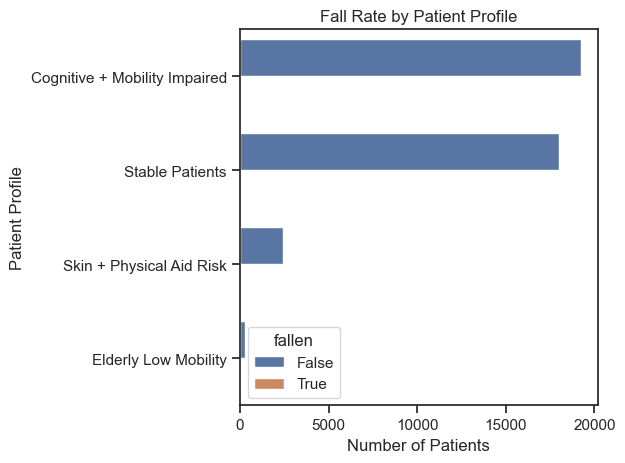

In [54]:
# Already have these:
# X_pca: from PCA on numerical features
# X_mca: from MCA on categorical + binary features

# Ensure column names are unique and meaningful
X_pca.columns = [f'pca{i+1}' for i in range(X_pca.shape[1])]
X_mca.columns = [f'mca{i+1}' for i in range(X_mca.shape[1])]

# Combine them
X_components = pd.concat([X_pca, X_mca], axis=1)

# Add patient ID or index if you want to track them
X_components['id'] = df['id'].values
from sklearn.cluster import KMeans

n_clusters = 4  # Tune this!
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_components['cluster'] = kmeans.fit_predict(X_components.drop(columns=['id']))
cluster_summary = X_components.groupby('cluster').mean()
print(cluster_summary[[f'pca{i+1}' for i in range(X_pca.shape[1])] + [f'mca{i+1}' for i in range(X_mca.shape[1])]])
cluster_labels = {
    0: "Cognitive + Mobility Impaired",
    1: "Skin + Physical Aid Risk",
    2: "Elderly Low Mobility",
    3: "Stable Patients"
}
X_components['profile'] = X_components['cluster'].map(cluster_labels)
X_components['fallen'] = df['fallen'].values

fall_summary = X_components.groupby('profile')['fallen'].mean().sort_values(ascending=False)
print("🚨 Fall rate per patient profile:")
print(fall_summary)
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=X_components, y='profile', hue='fallen')
plt.title("Fall Rate by Patient Profile")
plt.xlabel("Number of Patients")
plt.ylabel("Patient Profile")
plt.tight_layout()
plt.show()


## Plan: Feature Importance (Supervised): LOGISTIC REGRESSION VS. RANDOM FOREST/XGBOOST VS. SHAP VALUES


### XGBOOST

In [ ]:
import xgboost as xgb
import shap

# X_combined = your PCA + MCA components
X = X_combined.drop(columns=[target])
y = X_combined[target].astype(int)  # make sure it's binary (0/1)

# Train model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

# Initialize SHAP explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)


 98%|===================| 39217/40000 [00:35<00:00]        

📊 SHAP Summary Plot

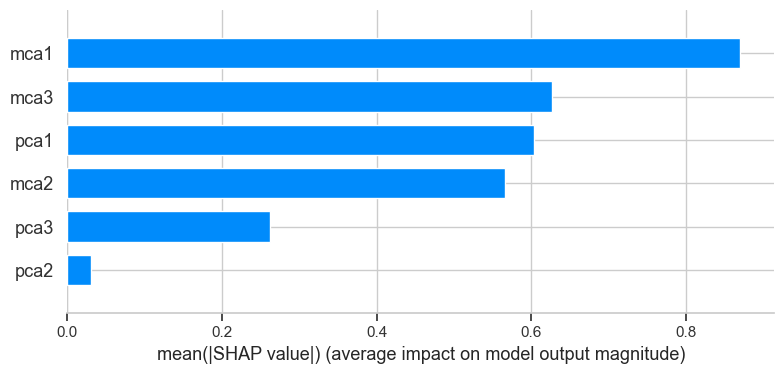

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar", show=True)


### 2. Outlier Detection and Handling

Outliers can skew the analysis, especially in medical data. Our approach to handle outliers includes:
- **Visualization:** Using boxplots and histograms to visually inspect the distribution of numeric variables.
- **Statistical Methods:** Using the Interquartile Range (IQR) to flag outliers. Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR will be flagged as potential outliers.
- **Handling Strategy:** Depending on the variable and the context, we may:
  - Cap the outliers at the boundary values
  - Remove the data points if they are likely errors
  - Use transformation methods (e.g., log transformation) if the distribution is highly skewed

The code below demonstrates the IQR-based detection for a sample numeric column (e.g., `age`). You should replicate or extend this approach for other numeric variables.


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# def visualize_outliers(df, column):
#     """
#     Creates a boxplot and histogram for a numeric column.
#     """
#     fig, axes = plt.subplots(1, 2, figsize=(14, 5))
#     sns.boxplot(y=df[column], ax=axes[0])
#     axes[0].set_title(f'Boxplot of {column}')

#     sns.histplot(df[column], kde=True, ax=axes[1])
#     axes[1].set_title(f'Histogram of {column}')

#     plt.tight_layout()
#     plt.show()


In [ ]:
# def detect_outliers_iqr(series):
#     """
#     Returns lower and upper bounds, and a mask for outliers in the Series.
#     """
#     Q1 = series.quantile(0.25)
#     Q3 = series.quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     outlier_mask = (series < lower_bound) | (series > upper_bound)

#     return lower_bound, upper_bound, outlier_mask


##### Outlier Handling: What’s the Difference?
Capping (Winsorization)	
- Replaces extreme outliers with a threshold (e.g. Q1 - 1.5IQR or Q3 + 1.5IQR)	
- Preserves all rows, reduces impact of outliers	
- Still keeps modified outlier values in dataset	
- When data is mostly valid but has extreme values

Removing
- Deletes rows that contain outlier values	
- Removes truly erroneous data	
- Loses information, can reduce sample size	
- When outliers are likely due to data entry error

Transforming	
- Applies a function (e.g., log, sqrt) to reduce skewness	
- Keeps all data, handles skew	
- Can complicate interpretability	
- When distribution is heavily skewed (e.g. income, lab results)

In [ ]:
# def handle_outliers(df, column, method="cap"):
#     """
#     Detects and handles outliers in a column using IQR.

#     Parameters:
#     - df: DataFrame
#     - column: str, column to process
#     - method: str, one of ["cap", "remove", "log"]

#     Returns:
#     - Modified DataFrame
#     """
#     lower, upper, mask = detect_outliers_iqr(df[column])
#     if method == "cap":
#         df[column] = df[column].clip(lower, upper)
#     elif method == "remove":
#         df = df[~mask]
#     elif method == "log":
#         df[column] = df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
#     else:
#         raise ValueError("Method must be one of ['cap', 'remove', 'log']")

#     print(f"{mask.sum()} outliers handled in '{column}' using '{method}' method.")
#     return df


In [ ]:
# for col in numerical_vars:
#     plt.figure(figsize=(12, 4))

#     plt.subplot(1, 2, 1)
#     sns.boxplot(x=df[col])
#     plt.title(f"Boxplot of {col}")

#     plt.subplot(1, 2, 2)
#     sns.histplot(df[col], kde=True)
#     plt.title(f"Histogram of {col}")

#     plt.tight_layout()
#     plt.show()

In [ ]:
# # |Skew| < 0.5 → Roughly symmetric → capping or removing is okay.
# # |Skew| ≥ 1 → Highly skewed → transformation might help.

# df[numerical_vars].skew().sort_values()


In [ ]:
# def outlier_proportion(series):
#     Q1 = series.quantile(0.25)
#     Q3 = series.quantile(0.75)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#     return ((series < lower) | (series > upper)).mean()

# outlier_stats = {col: outlier_proportion(df[col].dropna()) for col in numerical_vars}
# outlier_stats = pd.Series(outlier_stats).sort_values(ascending=False)
# print(outlier_stats)


| Feature Type | Skewness | % Outliers | Suggested Method                                       |
|--------------|----------|------------|--------------------------------------------------------|
| Symmetric    | Low      | < 5%       | Probably safe to **cap** or **remove**                |
| Symmetric    | Low      | > 20%      | Consider **capping** to retain data                   |
| Skewed       | High     | > 10%      | Try **log / sqrt transform**, or **cap after transform** |
| Any          | Any      | Clearly invalid values (e.g. `age > 120`) | **Remove** those values                |


In [ ]:
# for col in numerical_vars:
#     df = handle_outliers(df, col, method='cap')

Question: Regarding outliers in the dataset (not found until now)?

# Section 2: Data Exploration & Relationships

#### DIMENSIONALITY REDUCTION USING FAMD (Factor Analysis of Mixed Data)

Why: Our data is a mix of numerical, categorical, and binary.

FAMD combines:
- PCA for numerical features
- MCA for categorical features

It treats all variable types appropriately and returns components that represent all of them.


## Correlation analytics
- Heatmap
- Rule mining: Attecendent -> Consequence



## Visualization of meaningful insights
- Plotting age group -> Fall (depends on the previous result)

## Feature engineering
- Summarize various features/columns that are connected to each other -> Possibly stronger prediction

# Section 3: Model Development

## Logistic Regression (simple model)

## Neural Network (complex model)

# Section 4: Model Evaluation & Interpretation

## Strength & Weakness
- Parameters that influence the prediction result

## Stakeholder etc.
- Which model is preferable in which scenario/for which stakeholder


## Actionable insights